# Logistic regressions

## Purpose

The purpose of this script is to run logistic regressions that use machine learning methods to estimate whether or not a player's passing yards would be above or below a synthetically derived betting line, or above/below the player's mean yards. 

As with the data explore script, the data definitions are not contained here. See the data dictionary in the project write up to understand the variables.

## Structure 

__Set up__
* Import packages and functions
* Load data
* Replace NAs
* Visualise the data

__Logistic Regressions__
* Under Betting Line
    * Set up the regression
    * Calculate optimum tuning (penalty) parameter
    * Run the model on the test data
    * display confusion matrix
    * display Logistic vs no skill curves
    
* As above for 
    - Above Betting line
    - Above mean line

## Set up

__Import packages and functions__

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import sklearn
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

__Read in the NFL data.__

This has been filtered to only include players who played more than one season. This is necessary to ensure that the previous season's averages are not correlated with the y variables. The Y variables, by definition take into account games 15 and 16, which are not incorporated into the rolling season average. By ensuring there are more than 16 games (the min is 18) ensures that there are at least a few games in more than one season to incorporate into the betting line. These are also, as is explained in the write up, increased or decreased by a random factor between 5% and 15% to further decorrelate. 

In [2]:
NFL_df = pd.read_csv(r'C:\\Users\\tomam\\OneDrive\\Documents\\QMUL\\Group projects\\Big data\\NFL_Data_Project\\Multi_Season_DF_Past_Wk2.csv')

NA values are handled in the same way as for the initial regressions

In [3]:
outdoors_rows = NFL_df['Outdoors'] == 1
mean_outdoors_precip = NFL_df.loc[outdoors_rows, 'Precipitation'].mean()

for i in NFL_df['Outdoors']:
    if i == 1:
        NFL_df['Precipitation'].fillna(value = mean_outdoors_precip, inplace = True)
    else:
        NFL_df['Precipitation'].fillna(value = 0, inplace = True)
        
        
avg_1 = NFL_df['Prev_Vs_Opp_P_Yds'].mean()
NFL_df['Prev_Vs_Opp_P_Yds'].fillna(value = avg_1, inplace = True)

avg_2 = NFL_df['Prev_Vs_Opp_P_Atts'].mean()
NFL_df['Prev_Vs_Opp_P_Atts'].fillna(value = avg_2, inplace = True)

NFL_df.dropna(axis = 0, how = 'any', inplace = True)

Define the set of predictors

In [4]:
Full_Set_Of_Predictors = ['Prev_Wk_P_Yds','Seas_Av_P_Yds','Prev_Seas_Av_P_Yds','Prev_Seas_Av_P_Atts','Prev_Seas_Comp_Perc','Opp_Prev_Seas_Conc_P_Yds',
                      'Opp_Prev_Seas_Conc_P_Atts','Opp_Prev_Seas_Conc_R_Yds','Opp_Prev_Seas_Conc_R_Atts', 'Opp_Seas_Av_P_Yds',
                      'Opp_Seas_Av_P_Atts', 'Opp_Prev_Wk_P_Yds', 'Prev_Wk_R_Yds', 'Seas_Av_R_Yds', 'Prev_Vs_Opp_P_Yds', 'Prev_Vs_Opp_P_Atts',
                      'Precipitation', 'WindSpeed', 'Temperature',
                      'Outdoors', 'Home']


## Some visualisation

Firstly, see the distribution of Passing yards that are above or below the betting line.

<AxesSubplot:xlabel='P_Yds', ylabel='Over_B_Line'>

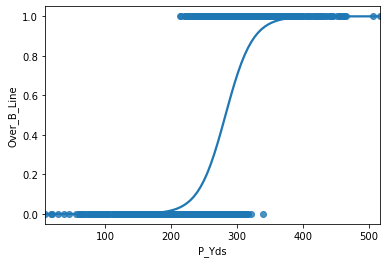

In [5]:
x = NFL_df['P_Yds']
y = NFL_df['Over_B_Line']

#plot logistic regression curve
sns.regplot(x=x, y=y, data=NFL_df, logistic=True, ci=None)

<AxesSubplot:xlabel='P_Yds', ylabel='Under_B_Line'>

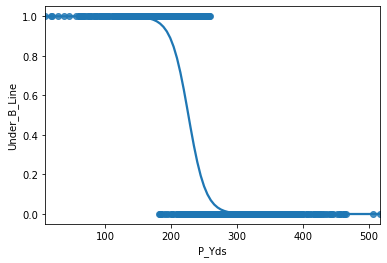

In [7]:
x = NFL_df['P_Yds']
y = NFL_df['Under_B_Line']

#plot logistic regression curve
sns.regplot(x=x, y=y, data=NFL_df, logistic=True, ci=None)

See the groups of data in each bucket

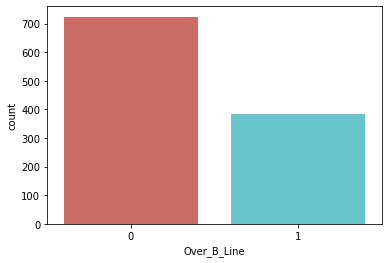

<Figure size 432x288 with 0 Axes>

In [8]:
sns.countplot(x=NFL_df['Over_B_Line'],data=NFL_df, palette='hls')
plt.show()
plt.savefig('count_plot')

These pairplots are included in the presentation slides. They suggest some mild association between opponent average passing yards, the variables on the x axis and being over the betting line

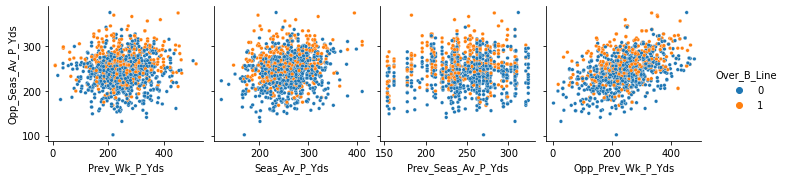

In [10]:
Pres_Pairplots1 = sns.pairplot(data=NFL_df,
                  y_vars= 'Opp_Seas_Av_P_Yds',
             
                  x_vars= ['Prev_Wk_P_Yds', 'Seas_Av_P_Yds',  'Prev_Seas_Av_P_Yds', 'Opp_Prev_Wk_P_Yds'],
             
                            hue='Over_B_Line',
                             plot_kws={"s": 13})

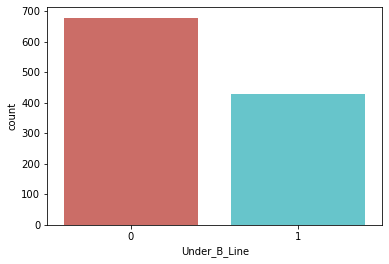

<Figure size 432x288 with 0 Axes>

In [12]:
sns.countplot(x=NFL_df['Under_B_Line'],data=NFL_df, palette='hls')
plt.show()
plt.savefig('count_plot')

These pairplots were also included in the presentation slides

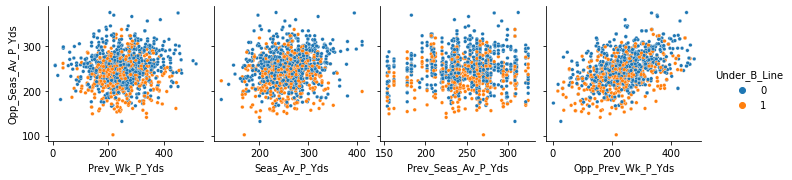

In [13]:
Pres_Pairplots2 = sns.pairplot(data=NFL_df,
                  y_vars= 'Opp_Seas_Av_P_Yds',
             
                  x_vars= ['Prev_Wk_P_Yds', 'Seas_Av_P_Yds',  'Prev_Seas_Av_P_Yds', 'Opp_Prev_Wk_P_Yds'],
             
                            hue='Under_B_Line',
                             plot_kws={"s": 13})

# Running logistic regressions

## Under B line

We start with the set column `Under_B_Line`. This is derived as the player mean minus a random number between 5% and 15%

In [37]:
# Define the predictor variables
X       = NFL_df[Full_Set_Of_Predictors]

# Add a constant
X       = sm.add_constant(X)

# Define the target variable: Under the betting line
y       = NFL_df['Under_B_Line']

# Split the data between test and train sets
# Stratify the data to preserve the same ratio of the target variable within the test and train sets as in the overall population
# assign random state = 42 to ensure we get the same results each time the kernel is run
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42 )

    Search for the optimum penalty term

In [18]:
# Define the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space}
  
# Instantiating logistic regression classifier
logreg = LogisticRegression(max_iter=100000)
  
# Instantiating the GridSearchCV object
logreg_cv = GridSearchCV(logreg, param_grid, cv = 5)
  
# Defnie the best parameter in the test set
logreg_cv.fit(X_test, y_test)
  
# Print the tuned parameters and score
print("Optimum Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 

Optimum Tuned Logistic Regression Parameters: {'C': 0.0007196856730011522}


    Run the model with the optimum parameter

In [29]:
model = LogisticRegression(penalty = 'l2',
                           solver = 'lbfgs',
    C= 0.0007, max_iter=1e5,
                          random_state=42)
model.fit(X_train, y_train)
yhat  = model.predict(X_test)

Print the confusion metrix from the application to the test set

In [31]:
print(metrics.confusion_matrix(y_test, yhat))

[[192  32]
 [ 86  56]]


    Create a visual confusion matrix using a heatmap

Text(0.5, 1.0, 'Whether Passing Yards < Low Bet')

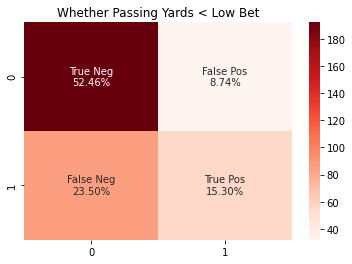

In [32]:
cf_matrix = confusion_matrix(y_test, yhat)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Reds')
plt.title('Whether Passing Yards < Low Bet')

    Build a graph to show logistic vs random assignment - how well the logistic regression can predict above/below the betting line.

Logistic: ROC AUC=0.699


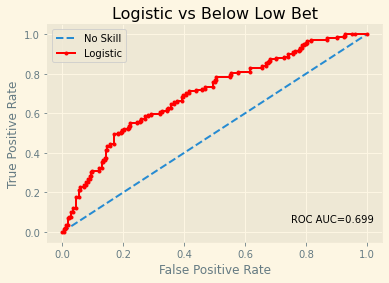

In [35]:

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# generate the predicted probabilities from the logistic regression
lr_probs = model.predict_proba(X_test)[:,1]
# Visualisation with plot_metric

ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

lr_auc = roc_auc_score(y_test, lr_probs)
print('Logistic: ROC AUC=%.3f' % (lr_auc))
with plt.style.context('Solarize_Light2'):
    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic', color = 'red')
    plt.title('Logistic vs Below Low Bet')
    
    plt.text(0.75, 0.05, 'ROC AUC=%.3f' % (lr_auc))

# axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

# show the legend
    plt.legend()

# show the plot
    plt.show()

In [36]:
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.699


The Logistic regression outperforms the random assignment reasonably well, especially given the lack of prediction suggested with the low R squared term in the passing yards regressions and logistic regression above. 

## Over B line

The next logistic regression we run is against an inverse variable: over the betting line, calculated in the same way as the under betting line variable, but with the addition of 5-15% instead of subtraction. The steps below follow the same format as below the betting line

In [51]:
# Define the predictors
X       = NFL_df[Full_Set_Of_Predictors]

# Add a constant
X       = sm.add_constant(X)

# Define the target variable: Passing yards
y       = NFL_df['Over_B_Line']

# We split the data frame into training and testing samples. We split the sample train = 2/3 test = 1/3. 
# The random_state is set to 42  to ensure we get the same results with each run

# stratify ensures that we have the same proportion of yeses and nos in test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42 )

    Search for the optimum tuning parameter

In [52]:
# Define the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space}
  
# Instantiating logistic regression classifier
logreg = LogisticRegression(max_iter=100000)
  
# Instantiating the GridSearchCV object
logreg_cv = GridSearchCV(logreg, param_grid, cv = 5)
  
# Defnie the best parameter in the test set
logreg_cv.fit(X_test, y_test)
  
# Print the tuned parameters and score
print("Optimum Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 

Optimum Tuned Logistic Regression Parameters: {'C': 8.483428982440725e-05}


    Run the model with the optimum tuning parameter

In [53]:
model = LogisticRegression(penalty = 'l2',
                           solver = 'lbfgs',
    C= 0.00008, max_iter=1e5,
                          random_state=42)
model.fit(X_train, y_train)
yhat  = model.predict(X_test)

In [54]:
print(metrics.confusion_matrix(y_test, yhat))

[[222  17]
 [ 94  33]]


    Visualise the data with a heatmap

Text(0.5, 1.0, 'Whether Passing Yards > High Bet')

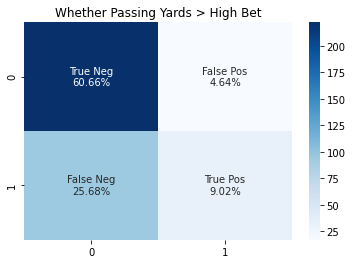

In [55]:
cf_matrix = confusion_matrix(y_test, yhat)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
plt.title('Whether Passing Yards > High Bet')

    Build a graph to show logistic vs random assignment - how well the logistic regression can predict above/below the betting line.

Logistic: ROC AUC=0.682


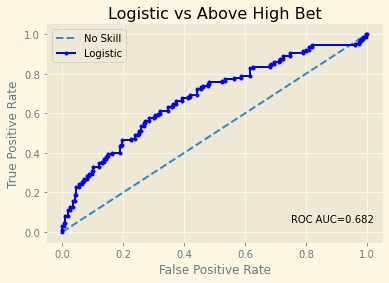

In [56]:

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# generate the predicted probabilities from the logistic regression
lr_probs = model.predict_proba(X_test)[:,1]
# Visualisation with plot_metric

ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

lr_auc = roc_auc_score(y_test, lr_probs)
print('Logistic: ROC AUC=%.3f' % (lr_auc))
with plt.style.context('Solarize_Light2'):
    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic', color = 'blue')
    plt.title('Logistic vs Above High Bet')
    
    plt.text(0.75, 0.05, 'ROC AUC=%.3f' % (lr_auc))

# axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

# show the legend
    plt.legend()

# show the plot
    plt.show()

In [58]:
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.682


Again, the logistic regression performs relatively well at predicting whether a player will be above the high bet.

### Mean line

The mean line regression will suffer from more statistical issues as it is not adjusted, either up or down thus might be inclined to be highly aligned with some of the regressors.

In [60]:
# Define the predictors
X       = NFL_df[Full_Set_Of_Predictors]

# Adding a constant reduces the R squared from 0.938 to 0.38
X       = sm.add_constant(X)

# Define the target variable: Passing yards
y       = NFL_df['mean_line']

# We split the data frame into training and testing samples. We split the sample train = 2/3 test = 1/3. 
# The random_state is set to 42  to ensure we get the same results with each run

# stratify ensures that we have the same proportion of yeses and nos in test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42 )

In [61]:
# Define the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space}
  
# Instantiating logistic regression classifier
logreg = LogisticRegression(max_iter=100000)
  
# Instantiating the GridSearchCV object
logreg_cv = GridSearchCV(logreg, param_grid, cv = 5)
  
# Defnie the best parameter in the test set
logreg_cv.fit(X_test, y_test)
  
# Print the tuned parameters and score
print("Optimum Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 

Optimum Tuned Logistic Regression Parameters: {'C': 19306.977288832535}


In [62]:
model = LogisticRegression(penalty = 'l2',
                           solver = 'lbfgs',
    C= 19307, max_iter=1e5,
                          random_state=42)
model.fit(X_train, y_train)
yhat  = model.predict(X_test)

In [63]:
print(metrics.confusion_matrix(y_test, yhat))

[[130  60]
 [ 76 100]]


Text(0.5, 1.0, 'Whether Passing Yards > Player mean')

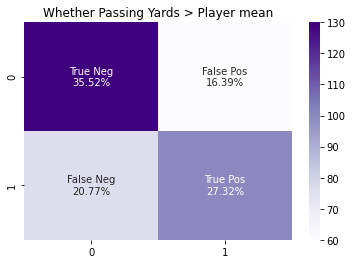

In [64]:
cf_matrix = confusion_matrix(y_test, yhat)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Purples')
plt.title('Whether Passing Yards > Player mean')

Logistic: ROC AUC=0.673


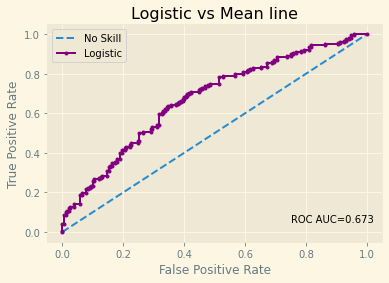

In [65]:

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# generate the predicted probabilities from the logistic regression
lr_probs = model.predict_proba(X_test)[:,1]
# Visualisation with plot_metric

ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

lr_auc = roc_auc_score(y_test, lr_probs)
print('Logistic: ROC AUC=%.3f' % (lr_auc))
with plt.style.context('Solarize_Light2'):
    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic', color = 'purple')
    plt.title('Logistic vs Mean line')
    
    plt.text(0.75, 0.05, 'ROC AUC=%.3f' % (lr_auc))

# axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

# show the legend
    plt.legend()

# show the plot
    plt.show()


In [66]:
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.673


Similar to the above betting line and below betting line, the model outperforms the random assignment